In [31]:
import utils
import quantus

%matplotlib inline


In [32]:
!pip install pytorch_grad_cam

ERROR: Could not find a version that satisfies the requirement pytorch_grad_cam (from versions: none)
ERROR: No matching distribution found for pytorch_grad_cam


In [33]:
import cv2
import numpy as np

def resize_image(image_path, target_size=(224, 224)):

    img = cv2.imread(image_path)
    
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    
    img_rgb = img[..., ::-1]
    
   
    img_resized = cv2.resize(img_rgb, target_size)
    

    img_normalized = img_resized / 255.0
    

    if img_normalized.shape[2] != 3:
        raise ValueError("Image does not have 3 channels")
    
    return img_normalized


image_path = 'sign.jpeg'


processed_image = resize_image(image_path)

# For comparison or verification
img = np.array(cv2.imread(image_path))[..., ::-1] / 255.0
img = cv2.resize(img, (224, 224))

In [34]:
import torch

mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)

X = (torch.FloatTensor(img[np.newaxis].transpose([0,3,1,2])*1) - mean) / std

In [35]:
import torchvision

model = torchvision.models.vgg16(pretrained=True); 
model.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

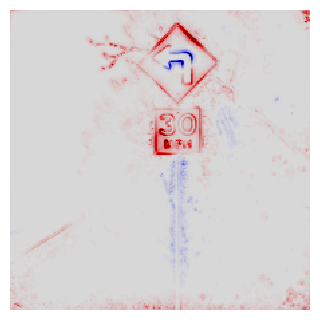

In [36]:

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from PIL import Image


def heatmap(R):

    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))

    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:,0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    return my_cmap,b

relevance_maps = []
os.makedirs('heatmap_images',exist_ok=True)
gamma_values = [0, 1, 10, 50, 100, 250, 500, 1000, 2500, 5000, 10000, 100000]
epsilon = 1e-7
gamma = 100
layers = list(model._modules['features']) + utils.toconv(list(model._modules['classifier']))
L = len(layers)
A = [X] + [None] * L
for l in range(L):
    A[l + 1] = layers[l].forward(A[l])
scores = np.array(A[-1].data.view(-1))
ind = np.argsort(-scores)
T = torch.FloatTensor((1.0 * (np.arange(1000) == 483).reshape([1, 1000, 1, 1])))
R = [None] * L + [(A[-1] * T).data] 

for l in range(1, L)[::-1]:
    A[l] = A[l].data.requires_grad_(True)
    if isinstance(layers[l], torch.nn.MaxPool2d):
        layers[l] = torch.nn.AvgPool2d(2)
    if isinstance(layers[l], torch.nn.Conv2d) or isinstance(layers[l], torch.nn.AvgPool2d):
      
      
        #  Modified LRP
        # if l <= 10:                 rho = lambda p: p  ;                                        incr = lambda z: z + epsilon
        # elif 11 <= l <= 20:         rho = lambda p: p + gamma * p.clamp(min=0)  ;               incr = lambda z: z + epsilon
        # elif 21 <= l <= 30:         rho = lambda p: p  ;                                        incr = lambda z: z + epsilon
        # elif l>=31:                 rho = lambda p: p  ;                                        incr = lambda z: z + epsilon


        # Original LRP
        if l <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9  
        if 17 <= l <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        if l >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9

        z = incr(utils.newlayer(layers[l], rho).forward(A[l]))  
        s = (R[l + 1] / z).data  
        (z * s).sum().backward()
        c = A[l].grad  
        R[l] = (A[l] * c).data  
        
    else:
        R[l] = R[l + 1]
    
for i, l in enumerate([1]):

    A[0] = (A[0].data).requires_grad_(True)

    lb = (A[0].data*0+(0-mean)/std).requires_grad_(True)
    hb = (A[0].data*0+(1-mean)/std).requires_grad_(True)

    z = layers[0].forward(A[0]) + 1e-9                                     # step 1 (a)
    z -= utils.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
    z -= utils.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
    s = (R[1]/z).data                                                      # step 2
    (z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad            # step 3
    R[0] = (A[0]*c+lb*cp+hb*cm).data                                       # step 4


    my_cmap, b = heatmap(np.array(R[0][0]).sum(axis=0))
    plt.figure(figsize=(3, 3))
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.axis('off')
    plt.imshow(np.array(R[l][0]).sum(axis=0), cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
    # plt.savefig(f'heatmap_images/heatmap_{gamma}.png')
    plt.show()
    plt.close()

    



Top Prediction:
Class ID: 919
Class Name: ['n06794110', 'street_sign']
Probability: 0.9047


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


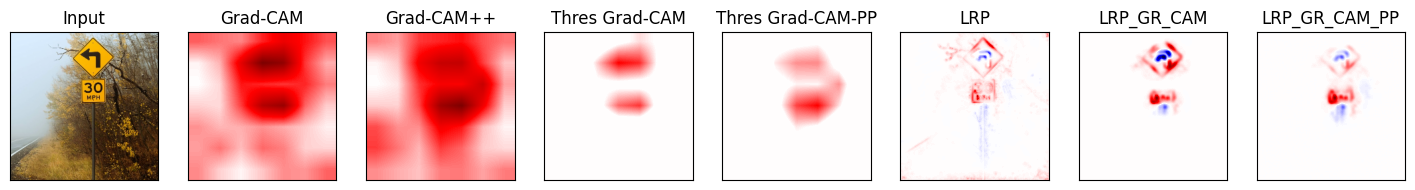

In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
import json


# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Preprocess the image and add a batch dimension
input_tensor = X.to(device)  # Assuming X is already in the correct shape

# Make the prediction
with torch.no_grad():
    output = model(input_tensor)

# Apply softmax to get probabilities
probabilities = torch.nn.functional.softmax(output[0], dim=0)

with open('imagenet_class_index.json') as f:
    labels = json.load(f)

# Get the top prediction
top_prob, top_catid = torch.max(probabilities, dim=0)

# Get the class name for the top prediction
top_prediction_index = top_catid.item()
top_prediction_prob = top_prob.item()
top_prediction_name = labels.get(str(top_prediction_index), "Unknown class")

# Print the top prediction details
print(f"Top Prediction:")
print(f"Class ID: {top_prediction_index}")
print(f"Class Name: {top_prediction_name}")
print(f"Probability: {top_prediction_prob:.4f}")


target_index = torch.argmax(probabilities).item()
# Initialize GradCAM and GradCAM++
grad_cam = GradCAM(model=model, target_layers=[model.features[-1]])
grad_cam_pp = GradCAMPlusPlus(model=model, target_layers=[model.features[-1]])

# Apply GradCAM and GradCAM++
grayscale_grad_cam = grad_cam(input_tensor=input_tensor)
grayscale_grad_cam_pp = grad_cam_pp(input_tensor=input_tensor)

# Process LRP attributions
attributions_lrp_np = R[0].cpu().detach().numpy()
attributions_lrp_np = np.transpose(attributions_lrp_np, (0, 2, 3, 1))
attributions_lrp_np = np.average(attributions_lrp_np, axis=3)
attributions_lrp_np = (attributions_lrp_np.T / np.max(attributions_lrp_np, axis=(1, 2)).T).T

# Threshold GradCAM results
grayscale_grad_cam_thr = np.copy(grayscale_grad_cam)
grayscale_grad_cam_thr = grayscale_grad_cam_thr - 0.5
grayscale_grad_cam_thr = np.clip(grayscale_grad_cam_thr, 0, 1)
product_grad_cam = attributions_lrp_np * grayscale_grad_cam_thr
product_grad_cam = (product_grad_cam.T / np.max(product_grad_cam, axis=(1, 2)).T).T


# Threshold GradCAMPP results
grayscale_grad_cam_pp_thr = np.copy(grayscale_grad_cam_pp)
grayscale_grad_cam_pp_thr = grayscale_grad_cam_pp_thr - 0.5
grayscale_grad_cam_pp_thr = np.clip(grayscale_grad_cam_pp_thr, 0, 1)
product_grad_cam_pp = attributions_lrp_np * grayscale_grad_cam_pp_thr
product_grad_cam_pp = (product_grad_cam_pp.T / np.max(product_grad_cam_pp, axis=(1, 2)).T).T

# Smooth the GradCAM result
smoothed_grad_cam = np.zeros(product_grad_cam.shape)
for i in range(0, product_grad_cam.shape[0]):
    smoothed_grad_cam[i] = cv2.GaussianBlur(product_grad_cam[i], (5, 5), cv2.BORDER_DEFAULT)
    smoothed_grad_cam[i] = smoothed_grad_cam[i] / np.max(smoothed_grad_cam[i])

# Smooth the GradCAM result
smoothed_grad_cam_pp = np.zeros(product_grad_cam_pp.shape)
for i in range(0, product_grad_cam_pp.shape[0]):
    smoothed_grad_cam_pp[i] = cv2.GaussianBlur(product_grad_cam_pp[i], (5, 5), cv2.BORDER_DEFAULT)
    smoothed_grad_cam_pp[i] = smoothed_grad_cam_pp[i] / np.max(smoothed_grad_cam_pp[i])

# Plot results
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(18, 4.5))
axes[0].imshow(np.moveaxis(quantus.normalise_func.denormalise(input_tensor[0].cpu().detach().numpy(), mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])), 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text("Input")
axes[1].imshow(grayscale_grad_cam[0], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[1].title.set_text("Grad-CAM")
axes[2].imshow(grayscale_grad_cam_pp[0], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[2].title.set_text("Grad-CAM++")
axes[3].imshow(grayscale_grad_cam_thr[0], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[3].title.set_text("Thres Grad-CAM")
axes[4].imshow(grayscale_grad_cam_pp_thr[0], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[4].title.set_text("Thres Grad-CAM-PP")
axes[5].imshow(attributions_lrp_np[0], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[5].title.set_text("LRP")
axes[6].imshow(smoothed_grad_cam[0], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[6].title.set_text("LRP_GR_CAM")
axes[7].imshow(smoothed_grad_cam_pp[0], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[7].title.set_text("LRP_GR_CAM_PP")
for i in range(0, 8):
    axes[i].axis("on")
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])

plt.savefig('example.png', bbox_inches='tight')
plt.show()

In [38]:
# image_files = [os.path.join('heatmap_images', x) for x in os.listdir('heatmap_images')]
# images = [Image.open(img) for img in image_files]
# images[0].save('LRP.gif',
#                save_all=True, append_images=images[1:], optimize=False, duration=500, loop=0)